In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import mlflow
from mlflow.models import infer_signature

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier


from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# Funciones de Yellow Brick
from yellowbrick.classifier import (
    ConfusionMatrix
)

# Importar xgboost
# import xgboost as xgb

sns.set_palette("colorblind")
SEED = 42

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://0.0.0.0:5000")

ModuleNotFoundError: No module named 'xgboost'

In [12]:
engine_df = pd.read_csv("../data/interim/engine_data_w_efficiency.csv")
engine_df.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition,Coolant Efficiency,Oil Efficiency
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1,0.116617,0.000017
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0,0.094116,0.000015
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1,0.153165,0.000025
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,1,0.151743,0.000029
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0,0.140550,0.000021


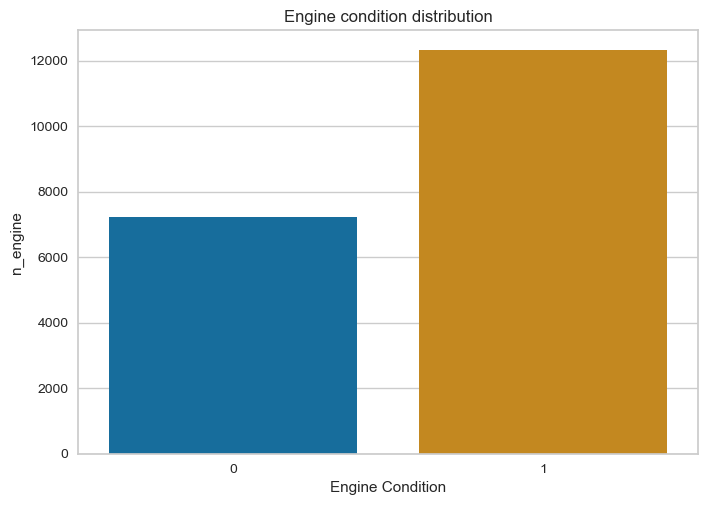

In [13]:
sns.barplot(
    data = (engine_df
            .groupby(['Engine Condition'])
            .size()
            .reset_index(name = 'n_engine')),
    x = 'Engine Condition',
    y = 'n_engine'
)
plt.title("Engine condition distribution")
plt.show()

In [14]:
def downsampling(df: pd.DataFrame, label: str, minority:any, mayority: any, seed: int = SEED):
    majority_random_selection = (
        df.loc[df[label] == mayority].sample(
            n = df.groupby([label]).size()[minority],
            random_state = SEED
        )
    )
    minority_selection = df.loc[df[label] == minority]
    return pd.concat([
        majority_random_selection,
        minority_selection
    ])
    

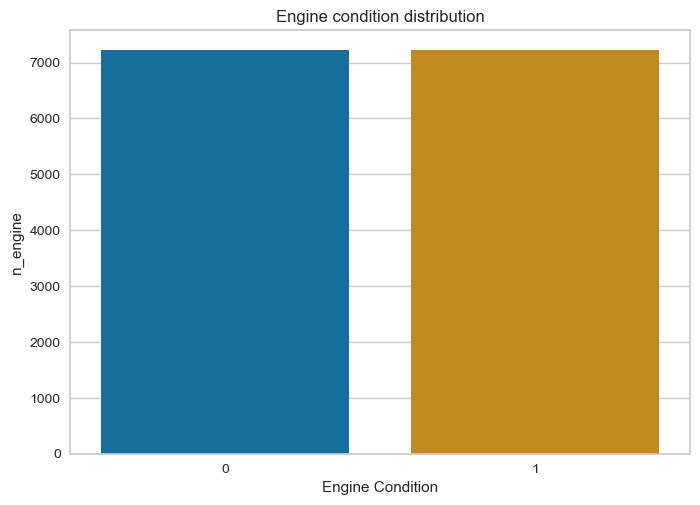

In [15]:
# Do Downsampling for imbalance class 
engine_downsampled_df = downsampling(
    engine_df, 
    label='Engine Condition', 
    minority=0, 
    mayority=1, 
    seed=SEED
)

sns.barplot(
    data = (engine_downsampled_df
            .groupby(['Engine Condition'])
            .size()
            .reset_index(name = 'n_engine')),
    x = 'Engine Condition',
    y = 'n_engine'
)
plt.title("Engine condition distribution")
plt.show()

In [16]:
engine_X = engine_df.drop("Engine Condition", axis=1)
engine_Y = engine_df["Engine Condition"]

downsampled_X = engine_downsampled_df.drop("Engine Condition", axis=1)
downsampled_Y = engine_downsampled_df["Engine Condition"]

engine_downsampled_df.to_csv('./../data/interim/engine_data_w_efficiency_downsampled.csv', index=False)

engine_X.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Coolant Efficiency,Oil Efficiency
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,0.116617,0.000017
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0.094116,0.000015
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,0.153165,0.000025
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,0.151743,0.000029
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0.140550,0.000021


In [17]:
rpm_idx, oil_pressure_idx, coolant_pressure_idx, oil_temp_idx, coolant_temp_idx = 0, 1, 3, 4, 5

class AttributesAdder(BaseEstimator, TransformerMixin):
    
    # Constructor of the Class
    def __init__(self, add_oil_system=True, add_coolant_system=True):
        self.add_oil_system = add_oil_system
        self.add_coolant_system = add_coolant_system
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.add_oil_system:
            oil_efficiency = 1 / (X[:, rpm_idx] * X[:, oil_temp_idx])
            X = np.c_[X, oil_efficiency]
            
        if self.add_coolant_system:
            cool_efficiency = (1 / X[:, rpm_idx]) * X[:, coolant_temp_idx]
            X = np.c_[X, cool_efficiency]
            
        return X   

In [18]:
def model_insigth_pipeline(
    clf,
    experiment_name: str,
    X: pd.DataFrame, 
    y: pd.Series,
    compare_results: pd.DataFrame, 
):
    # Create a new MLflow Experiment
    mlflow.set_experiment(experiment_name) 
    
    prep_pipe = Pipeline([
        ("attr_adder", AttributesAdder()),
        ("std_scaler", StandardScaler())
    ])
    
    data_prepared = prep_pipe.fit_transform(X.values)
    X_train, X_test, y_train, y_test = train_test_split(
        data_prepared, y, 
        test_size=0.2, 
        random_state=SEED,
        stratify=y
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train,
        test_size=X_test.shape[0],
        random_state=SEED,
        stratify=y_train
    )
    
    clf_model = clf.fit(X_train, y_train)
    predictions = clf_model.predict(X_test)
    
    insight = {
        # 'model': experiment_name,
        'auc': roc_auc_score(y_test, predictions),
        'score': f1_score(y_test, predictions) ,
        'precision': precision_score(y_test, predictions),
        'recall': recall_score(y_test, predictions)
        'accuracy': accuracy_score(y_test, predictions)
    }
    
    # Start an MLflow run
    with mlflow.start_run():
        # Log the hyperparameters
        mlflow.log_params(clf_model.get_params)

        # Log the loss metric
        mlflow.log_metrics(insight)

        # Set a tag that we can use to remind ourselves what this run was for
        mlflow.set_tag("Training Info", "Basic Clasifier model for Enigine Health")

        # Infer the model signature
        signature = infer_signature(X_train, lr.predict(X_train))

        # Log the model
        model_info = mlflow.sklearn.log_model(
            sk_model=clf_model,
            artifact_path="engine_health_model",
            signature=signature,
            input_example=X_train,
            registered_model_name="tracking"+experiment_name,
        )
    
    results = pd.DataFrame(insight, index=[compare_results.shape[0]])
    
    compare_results = pd.concat([compare_results,results], ignore_index=True)
    
    display(compare_results)

    cm = ConfusionMatrix(
        clf,
        classes=['Bad_condition','Good_condition']
    )
    cm.fit(X_train, y_train)
    cm.score(X_val, y_val)
    cm.show()

    return clf_model, compare_results

/var/folders/y8/k7c5p2ls0f3_m21w3lj_lftr0000gn/T/ipykernel_19003/1760922181.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  compare_results = pd.concat([compare_results,results], ignore_index=True)


,model,auc,score,precision,recall
0,Logistic regression,0.598019,0.761091,0.689167,0.849777


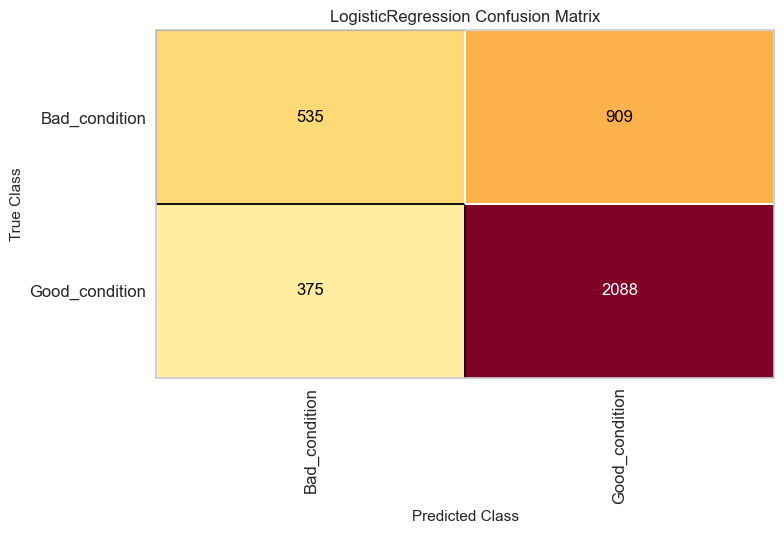

,model,auc,score,precision,recall
0,Logistic regression,0.598019,0.761091,0.689167,0.849777
1,Decision Tree,0.555000,0.669381,0.671294,0.667479


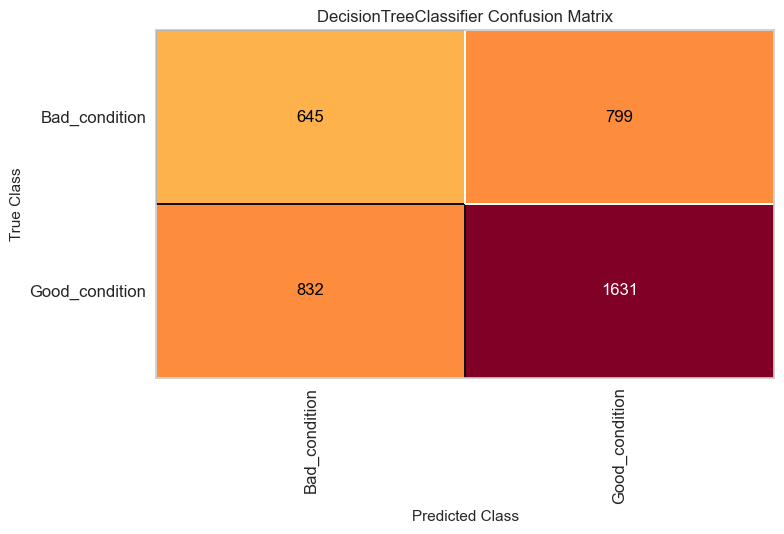

,model,auc,score,precision,recall
0,Logistic regression,0.598019,0.761091,0.689167,0.849777
1,Decision Tree,0.555000,0.669381,0.671294,0.667479
2,Random Forest,0.607150,0.749953,0.698808,0.809176


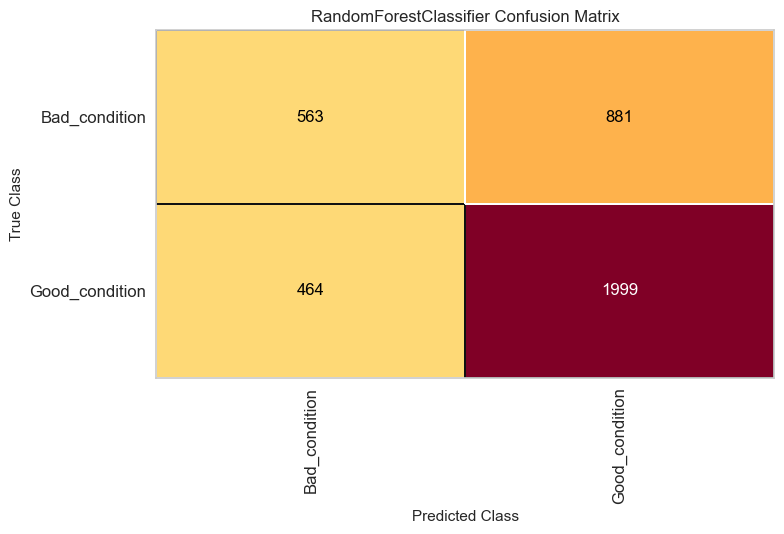

,model,auc,score,precision,recall
0,Logistic regression,0.598019,0.761091,0.689167,0.849777
1,Decision Tree,0.555000,0.669381,0.671294,0.667479
2,Random Forest,0.607150,0.749953,0.698808,0.809176
3,SGDC,0.564328,0.769178,0.665087,0.911896


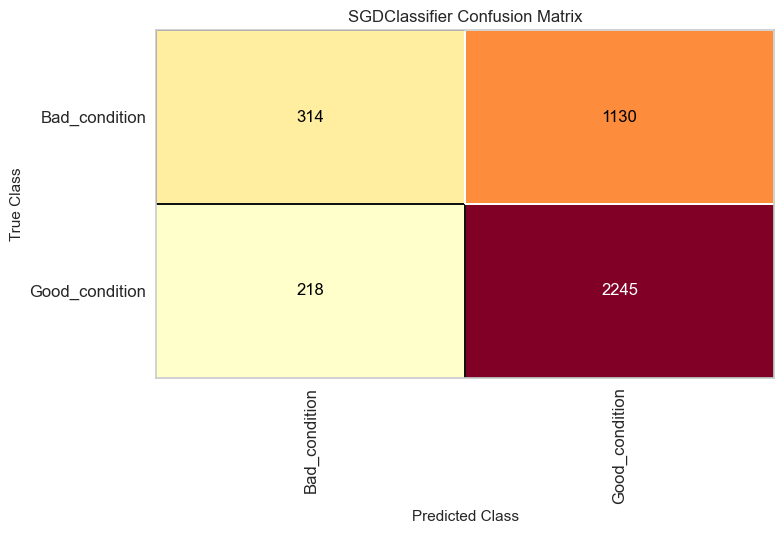

,model,auc,score,precision,recall
0,Logistic regression,0.598019,0.761091,0.689167,0.849777
1,Decision Tree,0.555000,0.669381,0.671294,0.667479
2,Random Forest,0.607150,0.749953,0.698808,0.809176
3,SGDC,0.564328,0.769178,0.665087,0.911896
4,Gradient Boosting,0.602579,0.759001,0.693056,0.838814


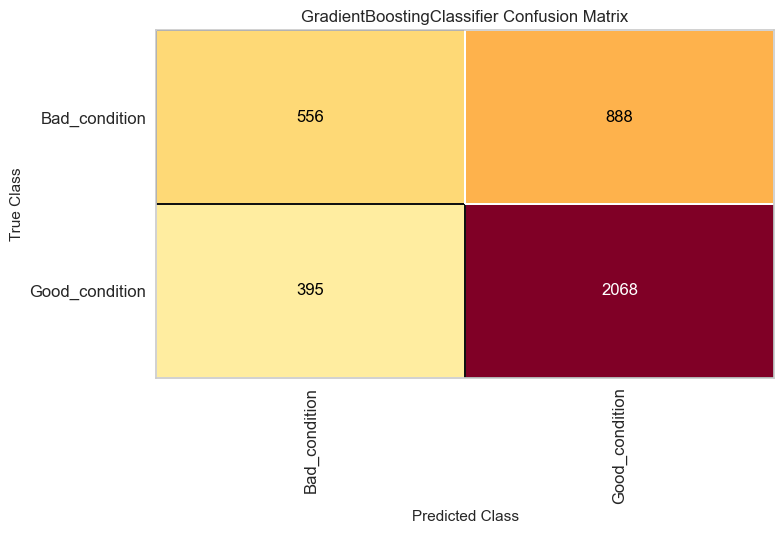

,model,auc,score,precision,recall
0,Logistic regression,0.598019,0.761091,0.689167,0.849777
1,Decision Tree,0.555000,0.669381,0.671294,0.667479
2,Random Forest,0.607150,0.749953,0.698808,0.809176
3,SGDC,0.564328,0.769178,0.665087,0.911896
4,Gradient Boosting,0.602579,0.759001,0.693056,0.838814
5,XGBoost,0.602600,0.740670,0.697383,0.789687


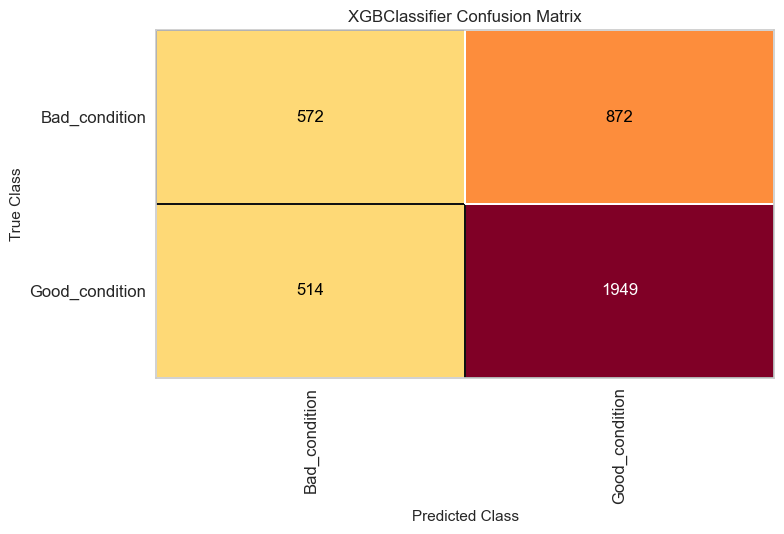

In [19]:
compare_results = pd.DataFrame(columns=['model','auc','score','precision','recall'])

models = {
    'Logistic regression': LogisticRegression(random_state=SEED),
    'Decision Tree': DecisionTreeClassifier(random_state=SEED),
    'Random Forest': RandomForestClassifier(random_state=SEED),
    'SGDC': SGDClassifier(random_state=SEED),
    'Gradient Boosting': GradientBoostingClassifier(random_state=SEED),
    'XGBoost': xgb.XGBClassifier(random_state=SEED),
}

for name, model in models.items():
    _,compare_results = model_insigth_pipeline(
        model,
        experiment_name=name,
        X=engine_X,
        y=engine_Y,
        compare_results=compare_results,
    )

In [20]:
compare_results

,model,auc,score,precision,recall
0,Logistic regression,0.598019,0.761091,0.689167,0.849777
1,Decision Tree,0.555000,0.669381,0.671294,0.667479
2,Random Forest,0.607150,0.749953,0.698808,0.809176
3,SGDC,0.564328,0.769178,0.665087,0.911896
4,Gradient Boosting,0.602579,0.759001,0.693056,0.838814
5,XGBoost,0.602600,0.740670,0.697383,0.789687


,model,auc,score,precision,recall
0,Logistic regression,0.598019,0.761091,0.689167,0.849777
1,Decision Tree,0.555000,0.669381,0.671294,0.667479
2,Random Forest,0.607150,0.749953,0.698808,0.809176
3,SGDC,0.564328,0.769178,0.665087,0.911896
4,Gradient Boosting,0.602579,0.759001,0.693056,0.838814
5,XGBoost,0.602600,0.740670,0.697383,0.789687
6,Logistic regression w downsample,0.631579,0.608824,0.648903,0.573407


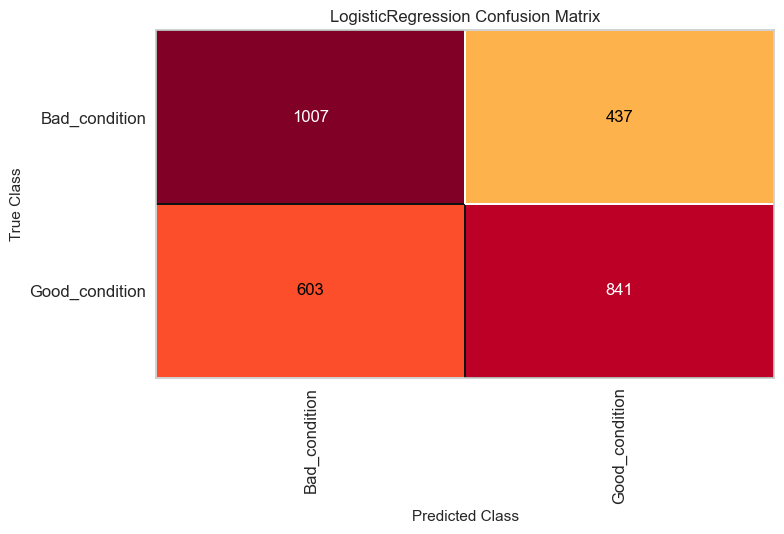

,model,auc,score,precision,recall
0,Logistic regression,0.598019,0.761091,0.689167,0.849777
1,Decision Tree,0.555000,0.669381,0.671294,0.667479
2,Random Forest,0.607150,0.749953,0.698808,0.809176
3,SGDC,0.564328,0.769178,0.665087,0.911896
4,Gradient Boosting,0.602579,0.759001,0.693056,0.838814
5,XGBoost,0.602600,0.740670,0.697383,0.789687
6,Logistic regression w downsample,0.631579,0.608824,0.648903,0.573407
7,Decision Tree w downsample,0.570291,0.574563,0.568907,0.580332


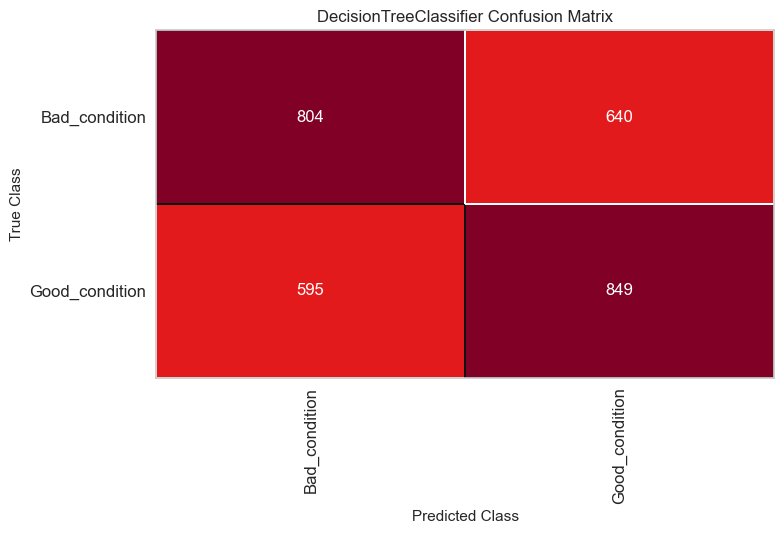

,model,auc,score,precision,recall
0,Logistic regression,0.598019,0.761091,0.689167,0.849777
1,Decision Tree,0.555000,0.669381,0.671294,0.667479
2,Random Forest,0.607150,0.749953,0.698808,0.809176
3,SGDC,0.564328,0.769178,0.665087,0.911896
4,Gradient Boosting,0.602579,0.759001,0.693056,0.838814
5,XGBoost,0.602600,0.740670,0.697383,0.789687
6,Logistic regression w downsample,0.631579,0.608824,0.648903,0.573407
7,Decision Tree w downsample,0.570291,0.574563,0.568907,0.580332
8,Random Forest w downsample,0.626731,0.612787,0.636567,0.590720


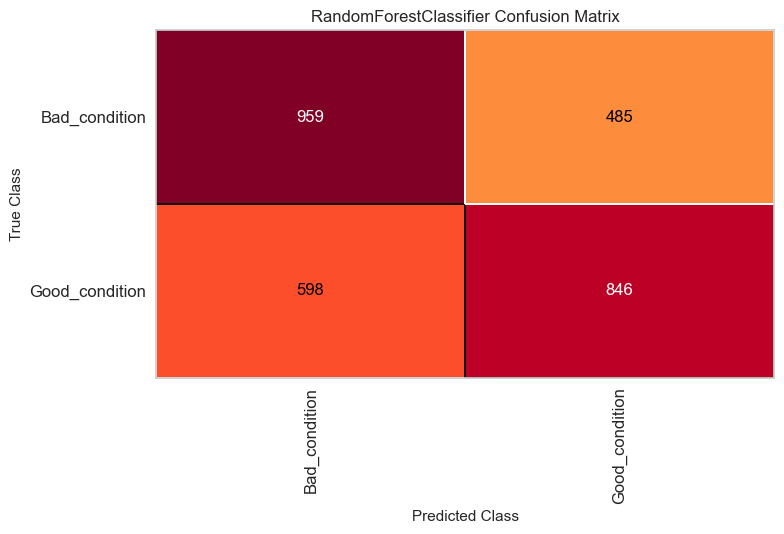

,model,auc,score,precision,recall
0,Logistic regression,0.598019,0.761091,0.689167,0.849777
1,Decision Tree,0.555000,0.669381,0.671294,0.667479
2,Random Forest,0.607150,0.749953,0.698808,0.809176
3,SGDC,0.564328,0.769178,0.665087,0.911896
4,Gradient Boosting,0.602579,0.759001,0.693056,0.838814
5,XGBoost,0.602600,0.740670,0.697383,0.789687
6,Logistic regression w downsample,0.631579,0.608824,0.648903,0.573407
7,Decision Tree w downsample,0.570291,0.574563,0.568907,0.580332
8,Random Forest w downsample,0.626731,0.612787,0.636567,0.590720
9,SGDC w downsample,0.608726,0.549801,0.647280,0.477839


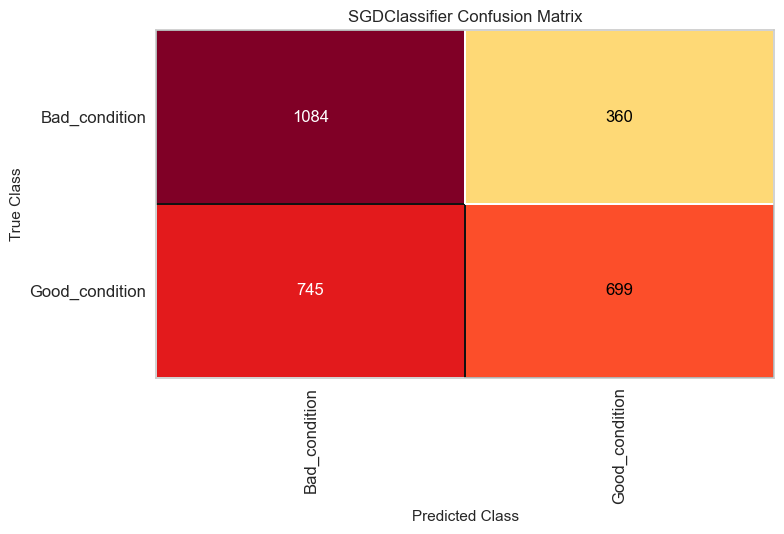

,model,auc,score,precision,recall
0,Logistic regression,0.598019,0.761091,0.689167,0.849777
1,Decision Tree,0.555000,0.669381,0.671294,0.667479
2,Random Forest,0.607150,0.749953,0.698808,0.809176
3,SGDC,0.564328,0.769178,0.665087,0.911896
4,Gradient Boosting,0.602579,0.759001,0.693056,0.838814
5,XGBoost,0.602600,0.740670,0.697383,0.789687
6,Logistic regression w downsample,0.631579,0.608824,0.648903,0.573407
7,Decision Tree w downsample,0.570291,0.574563,0.568907,0.580332
8,Random Forest w downsample,0.626731,0.612787,0.636567,0.590720
9,SGDC w downsample,0.608726,0.549801,0.647280,0.477839


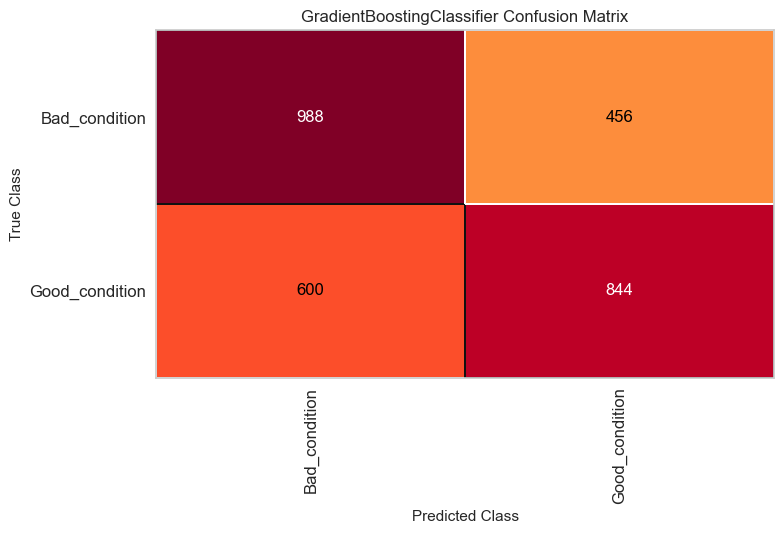

,model,auc,score,precision,recall
0,Logistic regression,0.598019,0.761091,0.689167,0.849777
1,Decision Tree,0.555000,0.669381,0.671294,0.667479
2,Random Forest,0.607150,0.749953,0.698808,0.809176
3,SGDC,0.564328,0.769178,0.665087,0.911896
4,Gradient Boosting,0.602579,0.759001,0.693056,0.838814
5,XGBoost,0.602600,0.740670,0.697383,0.789687
6,Logistic regression w downsample,0.631579,0.608824,0.648903,0.573407
7,Decision Tree w downsample,0.570291,0.574563,0.568907,0.580332
8,Random Forest w downsample,0.626731,0.612787,0.636567,0.590720
9,SGDC w downsample,0.608726,0.549801,0.647280,0.477839


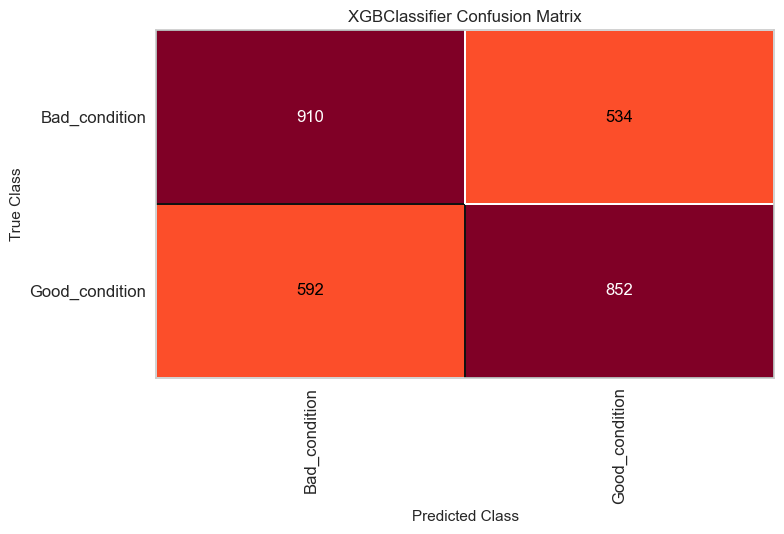

In [21]:
compare_results_downsampled = pd.DataFrame(columns=['model','auc','score','precision','recall'])

experiments = {
    'Logistic regression w downsample ': LogisticRegression(random_state=SEED),
    'Decision Tree w downsample': DecisionTreeClassifier(random_state=SEED),
    'Random Forest w downsample': RandomForestClassifier(random_state=SEED),
    'SGDC w downsample': SGDClassifier(random_state=SEED),
    'Gradient Boosting w downsample': GradientBoostingClassifier(random_state=SEED),
    'XGBoost w downsample': xgb.XGBClassifier(random_state=SEED),
}

for name in experiments:
    _,compare_results = model_insigth_pipeline(
        experiments[name],
        experiment_name= name,
        X= downsampled_X,
        y= downsampled_Y,
        compare_results=compare_results,
    )

In [22]:
compare_results

,model,auc,score,precision,recall
0,Logistic regression,0.598019,0.761091,0.689167,0.849777
1,Decision Tree,0.555000,0.669381,0.671294,0.667479
2,Random Forest,0.607150,0.749953,0.698808,0.809176
3,SGDC,0.564328,0.769178,0.665087,0.911896
4,Gradient Boosting,0.602579,0.759001,0.693056,0.838814
5,XGBoost,0.602600,0.740670,0.697383,0.789687
6,Logistic regression w downsample,0.631579,0.608824,0.648903,0.573407
7,Decision Tree w downsample,0.570291,0.574563,0.568907,0.580332
8,Random Forest w downsample,0.626731,0.612787,0.636567,0.590720
9,SGDC w downsample,0.608726,0.549801,0.647280,0.477839
